In [58]:
from systems.provided.mike.run_system import equities_system
from sysdata.sim.db_equities_sim_data import dbEquitiesSimData
from systems.trading_rules import TradingRule
from systems.provided.rob_system.rules import ewmac_calc_vol as ewmac, breakout
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import pandas as pd

plt.rc('figure', figsize=(30, 10))

In [80]:

def squeeze_momentum(close, high, low, lookback=20):

    rollingHigh = high.rolling(lookback).max()
    rollingLow = low.rolling(lookback).min()
    rollingClose = close.rolling(lookback).mean()

    avg = ((rollingHigh + rollingLow + rollingClose)/3).ffill()

    vol = close.rolling(lookback).std()

    y = (close - avg)
    X = pd.Series(1, y.index)

    model = RollingOLS(y, X, window=lookback)
    rres = model.fit()

    return rres.params['const']

trading_rules = dict(
    # mom8=TradingRule(squeeze_momentum, ['data.daily_prices', 'data.get_raw_high', 'data.get_raw_low'], dict(lookback=8)),
    # mom16=TradingRule(squeeze_momentum, ['data.daily_prices', 'data.get_raw_high', 'data.get_raw_low'], dict(lookback=20)),
    # mom32=TradingRule(squeeze_momentum, ['data.daily_prices', 'data.get_raw_high', 'data.get_raw_low'], dict(lookback=32)),

    # break8=TradingRule(breakout,[], dict(lookback=8)),
    # break16=TradingRule(breakout,[], dict(lookback=16)),
    # break32=TradingRule(breakout,[], dict(lookback=32)),
    # break64=TradingRule(breakout,[], dict(lookback=64)),
    # break128=TradingRule(breakout,[], dict(lookback=128)),

    ewmac8=TradingRule(ewmac, [], dict(Lfast=8, Lslow=32)),
    ewmac16=TradingRule(ewmac, [], dict(Lfast=16, Lslow=64)),
    ewmac32=TradingRule(ewmac, [], dict(Lfast=32, Lslow=128)),
    ewmac64=TradingRule(ewmac, [], dict(Lfast=64, Lslow=256)),
)

2022-07-08 21:22:49 {'type': 'dbEquitiesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2022-07-08 21:22:49 {'type': 'base_system', 'stage': 'config'}  Adding config defaults


/mnt/d/Users/Mike/src/pysystemtrade/sysobjects/equities_prices.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


<AxesSubplot:xlabel='index'>

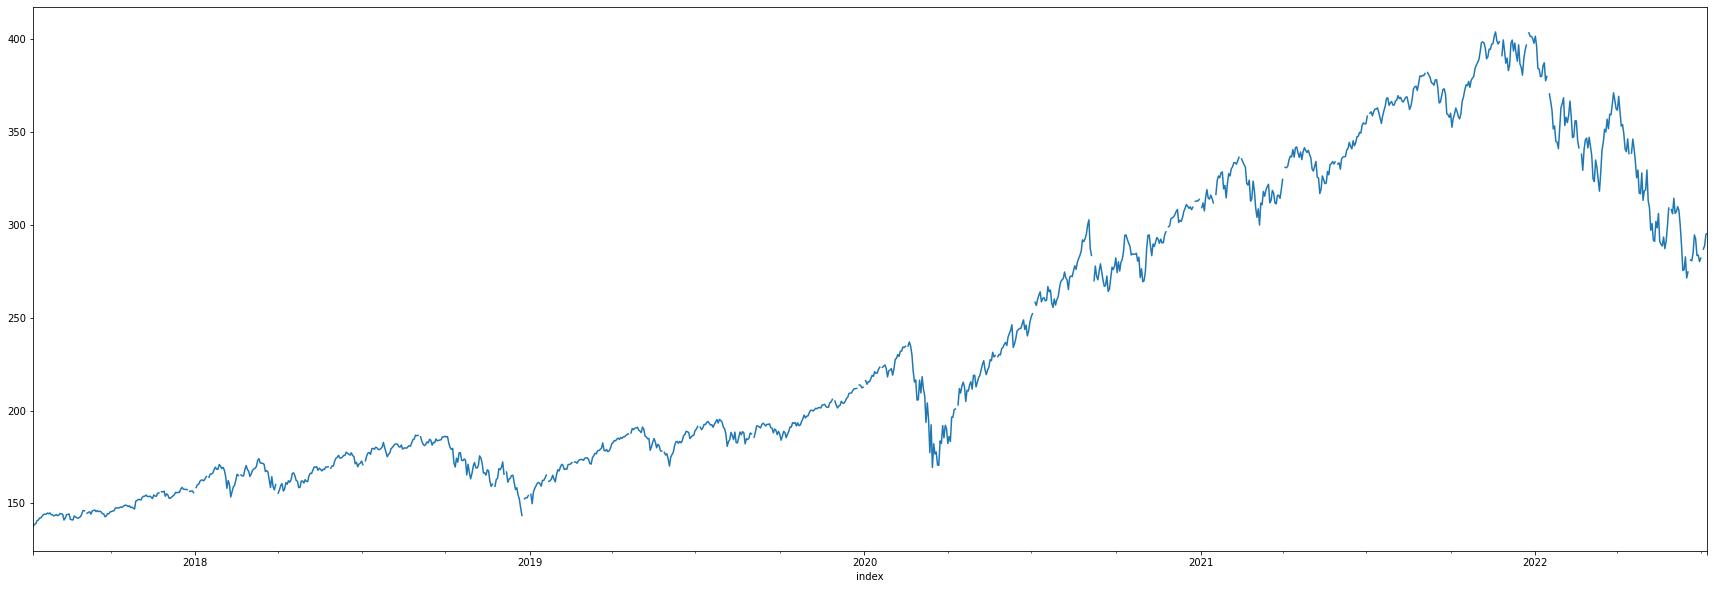

In [86]:
instrument = 'QQQ'


system = equities_system(dbEquitiesSimData(), rules=trading_rules)
system.config.instruments = [instrument]
system.config.start_date = '2017-07-07'
system.config.percentage_vol_target = 30
prices = system.data.daily_prices(instrument)
prices.plot()


2022-07-08 21:22:53 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2022-07-08 21:22:53 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2022-07-08 21:22:53 {'type': 'base_system'}  Following instruments removed entirely from sim: ['Another_thing', 'EXAMPLE', 'bad_thing']
2022-07-08 21:22:53 {'type': 'base_system', 'stage': 'combForecast', 'instrument_code': 'QQQ'}  Calculating combined forecast for QQQ
2022-07-08 21:22:53 {'type': 'base_system', 'stage': 'forecastScaleCap', 'instrument_code': 'QQQ', 'rule_variation_name': 'ewmac16'}  Calculating capped forecast for QQQ ewmac16
2022-07-08 21:22:53 {'type': 'base_system', 'stage': 'rules', 'instrument_code': 'QQQ', 'rule_variation_name': 'ewmac16'}  Calculating raw forecast QQQ for ewmac16
2022-07-08 21:22:53 {'type': 'base_system', 'stage': 'forecastScaleCap', 'instrument_code': 'QQQ', 'rule_variation_name': 'ewmac32'}  Ca

ewmac16    4.043394
ewmac32    1.111861
ewmac64    0.554484
ewmac8     6.616201
dtype: float64

1.2999044890162368

2022-07-08 21:23:00 {'type': 'base_system', 'stage': 'accounts'}  Calculating pandl for portfolio
2022-07-08 21:23:00 {'type': 'base_system', 'stage': 'positionSize'}  Getting vol target
2022-07-08 21:23:00 {'type': 'base_system', 'stage': 'accounts', 'instrument_code': 'QQQ'}  Calculating pandl for instrument for QQQ
2022-07-08 21:23:00 {'type': 'base_system', 'stage': 'portfolio', 'instrument_code': 'QQQ'}  Calculating notional position for QQQ
2022-07-08 21:23:00 {'type': 'base_system', 'stage': 'portfolio'}  Calculating instrument weights
2022-07-08 21:23:00 {'type': 'base_system', 'stage': 'portfolio'}  Calculating raw instrument weights
2022-07-08 21:23:00 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2022-07-08 21:23:00 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2022-07-08 21:23:00 {'type': 'base_system'}  Following instruments are marked as 'bad_markets':  

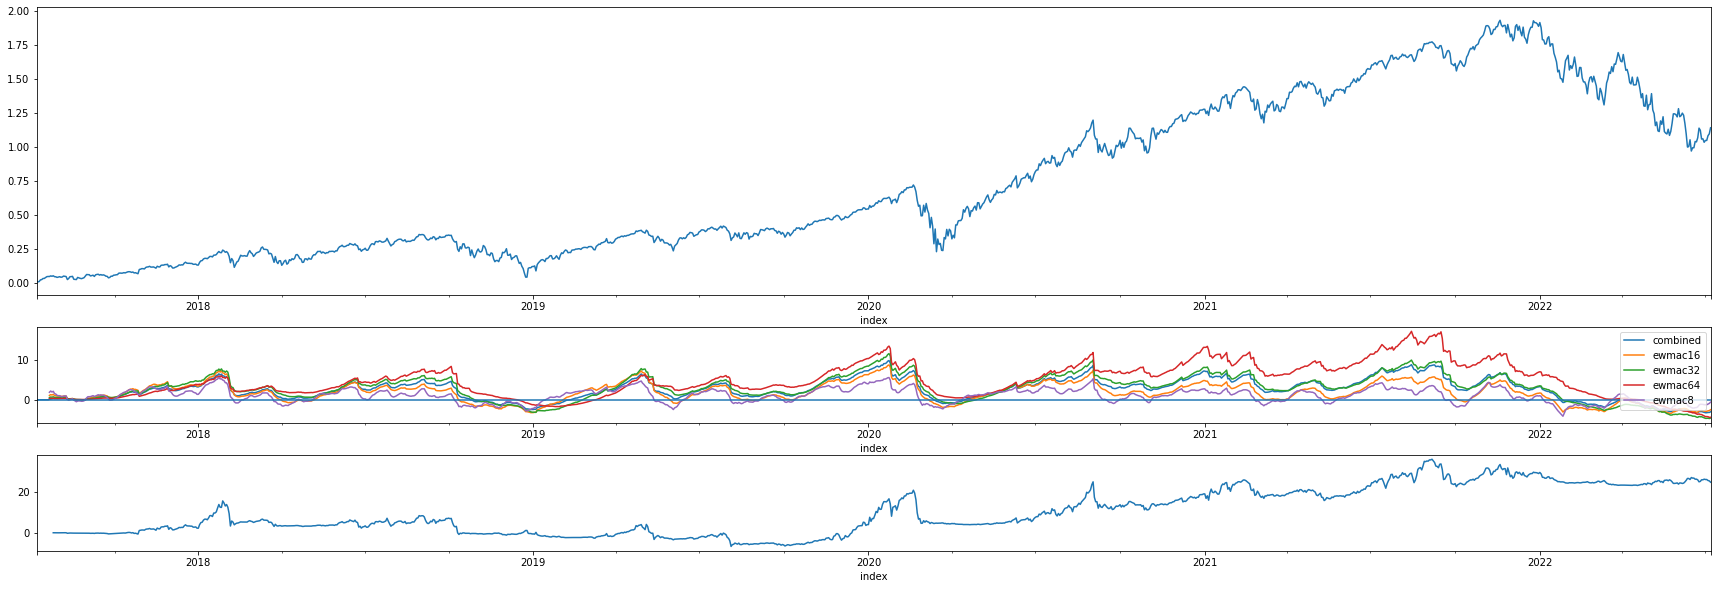

In [87]:


combindedForecast = system.combForecast.get_combined_forecast(instrument)
# combindedForecast.plot()

forecast = system.combForecast.get_all_forecasts(instrument)
# display(forecast.where(forecast*forecast.shift() > 0))

def func(x):
    # display(x)
    return x.where(x*x.shift()<0).count()

display(forecast.rolling(260).apply(func).mean())
display(combindedForecast.rolling(260).apply(func).mean())

gs_kw = dict(height_ratios=[3, 1, 1])
fig0, ax = plt.subplots(3,1, gridspec_kw=gs_kw)

s = slice(0,-1)
((prices[s].pct_change()+1).cumprod()-1).plot(ax=ax[0])
combindedForecast[s].rename('combined').plot(ax=ax[1])
forecast[s].plot(ax=ax[1])
ax[1].legend()
ax[1].axhline(0)
portfolio = system.accounts.portfolio()
portfolio.percent.curve()[s].plot(ax=ax[2])
plt.show()


In [88]:

system.accounts.portfolio().percent.stats()

[[('min', '-7.566'),
  ('max', '4.416'),
  ('median', '0.01901'),
  ('mean', '0.01918'),
  ('std', '0.8698'),
  ('skew', '-1.618'),
  ('ann_mean', '4.86'),
  ('ann_std', '13.92'),
  ('sharpe', '0.3492'),
  ('sortino', '0.3508'),
  ('avg_drawdown', '-10.37'),
  ('time_in_drawdown', '0.9497'),
  ('calmar', '0.2175'),
  ('avg_return_to_drawdown', '0.4686'),
  ('avg_loss', '-0.5627'),
  ('avg_gain', '0.4773'),
  ('gaintolossratio', '0.8482'),
  ('profitfactor', '1.08'),
  ('hitrate', '0.5602'),
  ('t_stat', '0.7927'),
  ('p_value', '0.4281')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]

index
2017-07-07    1
2017-07-10    1
2017-07-11    1
2017-07-12    1
2017-07-13    1
             ..
2022-07-04    1
2022-07-05    1
2022-07-06    1
2022-07-07    1
2022-07-08    1
Freq: B, Length: 1306, dtype: int64

,const
index,
2017-07-07,NaN
2017-07-10,NaN
2017-07-11,NaN
2017-07-12,NaN
2017-07-13,NaN
...,...
2022-07-04,-10.888114
2022-07-05,-11.881773
2022-07-06,-12.539748


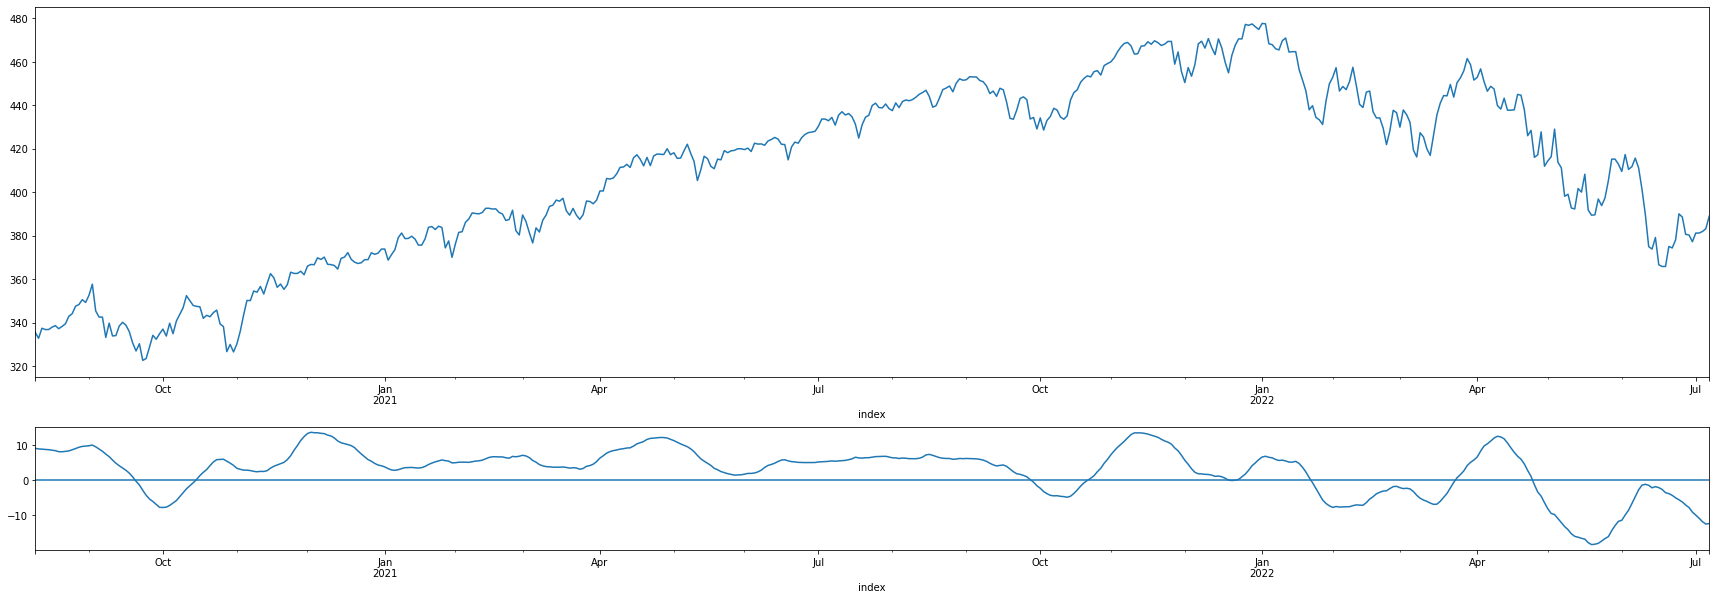

In [51]:
instrument = 'SPY'
lookback = 20

close = system.data.daily_prices(instrument).ffill()
high = system.data.get_raw_high(instrument).ffill()
low = system.data.get_raw_low(instrument).ffill()

rollingHigh = high.rolling(lookback).max()
# display(rollingHigh)
rollingLow = low.rolling(lookback).min()
# display(rollingLow)
rollingClose = close.rolling(lookback).mean()
# display(rollingClose)

avg = ((rollingHigh + rollingLow + rollingClose)/3).ffill()
# display(avg)

y = close - avg
X = pd.Series(1, y.index)

# y = close
# X = pd.DataFrame(close - avg)
# X['const'] = 1

display(X)

model = RollingOLS(y, X, window=lookback)
rres = model.fit()
display(rres.params)
# pred = rres.params['const'] + rres.params[0] * lookback
pred = rres.params['const']

gs_kw = dict(height_ratios=[3, 1])
fig0, ax = plt.subplots(2,1, gridspec_kw=gs_kw)

s = slice(-500,-1)
close[s].plot(ax=ax[0])
pred[s].plot(ax=ax[1])
ax[1].axhline(0)
plt.show()
# pred = ((rres.params['const'] + rres.params['X1'] * 20) / y - 1) * 100
# pred[-100:].plot()